Unzip datasets and prepare data:

In [4]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler

from multi_imbalance.datasets import load_datasets
from multi_imbalance.resampling.mdo import MDO
from multi_imbalance.utils.data import construct_flat_2pc_df, load_arff_dataset
from multi_imbalance.utils.min_int_maj import maj_int_min

%matplotlib inline
sns.set_style("darkgrid")


dataset = load_datasets()
print(dataset.keys())
dataset = dataset["new_ecoli"]
X, y = dataset.data, dataset.target
print(X[:5])
print(y[:5])

odict_keys(['1czysty-cut', '2delikatne-cut', '3mocniej-cut', '4delikatne-bezover-cut', 'balance-scale', 'cleveland', 'cleveland_v2', 'cmc', 'dermatology', 'glass', 'hayes-roth', 'new_ecoli', 'new_led7digit', 'new_vehicle', 'new_winequality-red', 'new_yeast', 'thyroid-newthyroid'])
[[0.49 0.29 0.48 0.5  0.56 0.24 0.35]
 [0.07 0.4  0.48 0.5  0.54 0.35 0.44]
 [0.56 0.4  0.48 0.5  0.49 0.37 0.46]
 [0.59 0.49 0.48 0.5  0.52 0.45 0.36]
 [0.23 0.32 0.48 0.5  0.55 0.25 0.35]]
[0 0 0 0 0]


Resample data using MDO algorithm

In [5]:
clf = MDO(k=5, k1_frac=0.3, maj_int_min=maj_int_min["new_ecoli"])
resampled_X, resampled_y = clf.fit_resample(X, y)

Compare results by plotting data in 2 dimensions

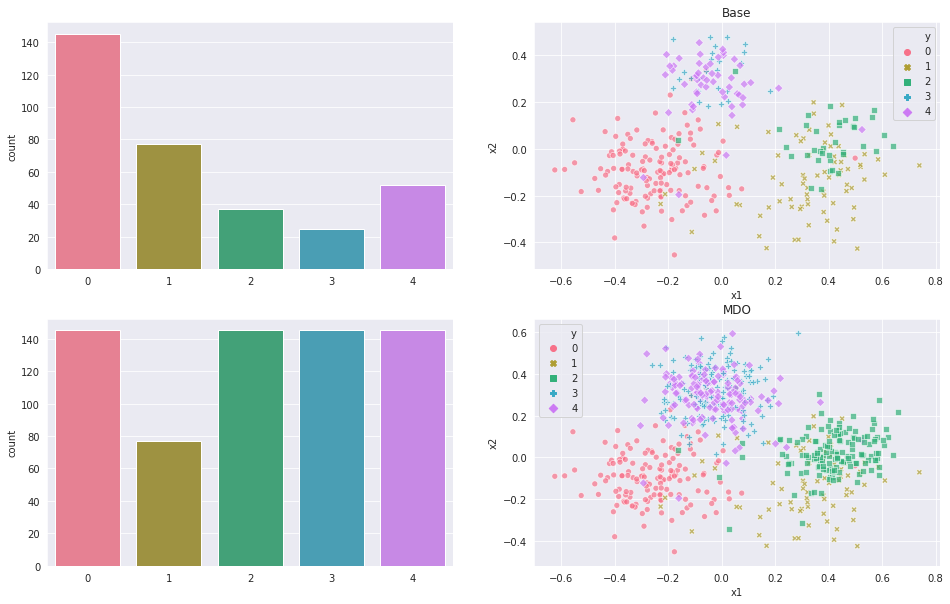

In [6]:
n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 10)
axs = axs.flatten()

axs[1].set_title("Base")
sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(
    x="x1",
    y="x2",
    hue="y",
    style="y",
    data=df,
    alpha=0.7,
    ax=axs[1],
    legend="full",
    palette=p,
)


axs[3].set_title("MDO")
sns.countplot(resampled_y, ax=axs[2], palette=p)
resampled_X = pca.transform(resampled_X)
df = construct_flat_2pc_df(resampled_X, resampled_y)
sns.scatterplot(
    x="x1",
    y="x2",
    hue="y",
    style="y",
    data=df,
    alpha=0.7,
    ax=axs[3],
    legend="full",
    palette=p,
)

In [7]:
X, y = load_arff_dataset(f"{os.getcwd()}/../../data/arff/new_ecoli.arff")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

pipeline = Pipeline([("scaler", StandardScaler()), ("mdo", MDO()), ("knn", KNN())])

pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        36
           1       0.88      0.37      0.52        19
           2       0.42      0.80      0.55        10
           3       1.00      1.00      1.00         6
           4       1.00      0.92      0.96        13

    accuracy                           0.82        84
   macro avg       0.84      0.82      0.80        84
weighted avg       0.87      0.82      0.81        84

